In [1]:
import matplotlib.pyplot as plt
from kronbinations import *
from unipolator import *

from Analysis_Code.parameter_sweep import *
from Analysis_Code.useful import *
from Analysis_Code.iplots import *
import Analysis_Code.discrete_quantum as dq
from Analysis_Code.Average_Infidelity_Integrator import *

In [2]:
def plot_infidelities(method_dicts, axis_labels, axis_types, axis_vars, plot_which=['mean'], figsize=(8,8), ps=0.68, ns=1, mini = 10**-15, ylog=True, indexes=None):
    legendary = []
    #generate figure with one axis
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    if indexes is None:
        indexes = np.arange(len(axis_vars[0]))
    x_vars = axis_vars[0][indexes]
    for method, method_dict in method_dicts.items():
        if not method == 'times':
            for plot_str in plot_which:
                # get the correct elements out
                mean_vals = method_dict[plot_str+'_I_mean'][indexes,0]
                std_vals = method_dict[plot_str+'_I_std'][indexes,0]
                # plot the mean and std
                if 'log' in axis_types[0]:
                    legendary, _ = std_plot(ax1, x_vars, [mean_vals], [std_vals], ps=ps, ns=ns, label=r'$I_{\mathrm{'+method+'}}$', legendary=legendary, support=[10**-16,1.0])
                else: # errorbarplot with caps of size 5 and linestyle '--'
                    ax1.errorbar(x_vars, mean_vals, yerr=std_vals, fmt='o', capsize=5, linestyle='--', label=r'$I_{\mathrm{'+method+'}}$')
    # set the axis labels
    ax1.set_xlabel(axis_labels[0])
    ax1.set_ylabel('$I = 1 - F$')
    ax1.set(xlim=(x_vars[0], x_vars[-1]))
    if ylog:
        ax1.set_yscale('log')
    if 'log' in axis_types[0]:
        ax1.set_xscale('log')
    # get ylim
    ylim = ax1.get_ylim()
    if ylim[0] < mini:
        ylim = (mini, ylim[1])
    if ylim[1] > 1:
        ylim = (ylim[0], 1)
    ax1.set(ylim=ylim)
    # if not log scale, set the ticks to integer values of axis_vars
    if 'log' not in axis_types[0]:
        ax1.set_xticks(axis_vars[0])
    # set the legend
    ax1.legend(*legendary)
    # Add axis ticks on the right and top  -> also ticks inside 
    ax1.tick_params(direction='in', top=True, right=True)
    # show plot
    plt.show()
    return fig, ax1

In [3]:
redo = False
figsize=(8,8)
# specify the variables by a dictionary 
num_controls = {'label': 'Number of controls', 'name': 'num_controls', 'def_val': 2, 'variation_vals': np.arange(1, 8), 'variation_type': 'int'}
hilbert_dim = {'label':'Hilbert space dimension', 'name': 'dim_hilbert', 'def_val': 8, 'variation_vals': 2**np.arange(1, 10), 'variation_type': 'log_int'}
control_amplitudes = {'label': 'Control amplitude ratio ($|H_i| / |H_0|$)', 'name': 'amp_ratio', 'def_val': 0.025, 'variation_vals': np.logspace(-3, 0, 61), 'variation_type': 'log'} # ([H_i>0| / |H_0|)
bins = {'label': 'Number of bins', 'name': 'bins', 'def_val': 1, 'variation_vals': np.arange(1,64), 'variation_type': 'log_int'}
all_parameter_dicts = [num_controls, hilbert_dim, control_amplitudes, bins] 

import_statements = ['Analysis_Code.Average_Infidelity_Integrator', 'kronbinations', 'unipolator', ['Analysis_Code.discrete_quantum', 'dq'], ['numpy', 'np'], 'from numba import jit', 'import timeit']
other_func = [timeit_autorange, initialize_rep_arrays, intitialize_integrators, mean_std]

0it [00:00, ?it/s]


————— Done with num_controls ———————————————————————————————————————————————————


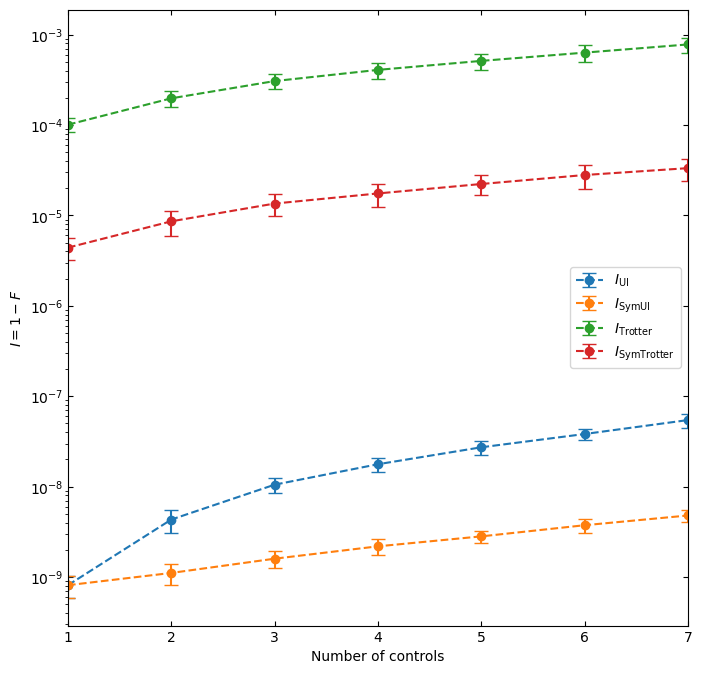

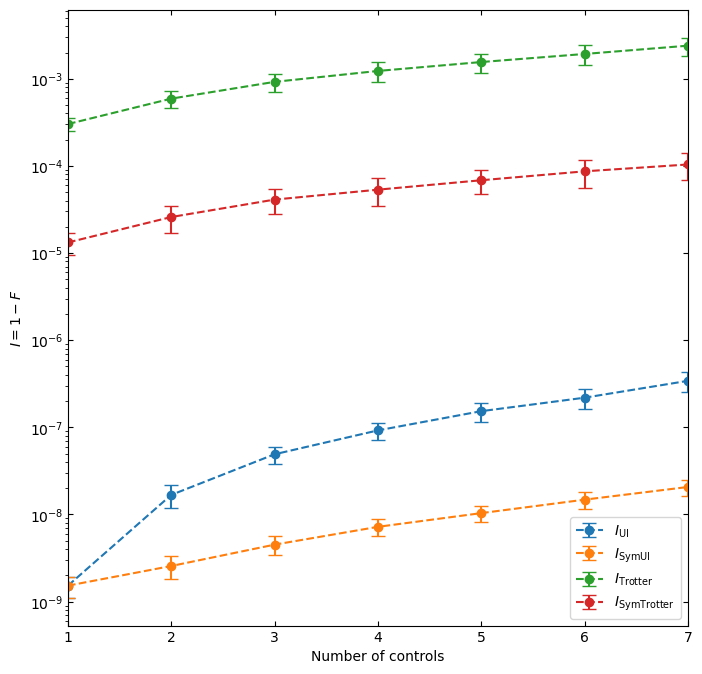

0it [00:00, ?it/s]


————— Done with bins ———————————————————————————————————————————————————————————


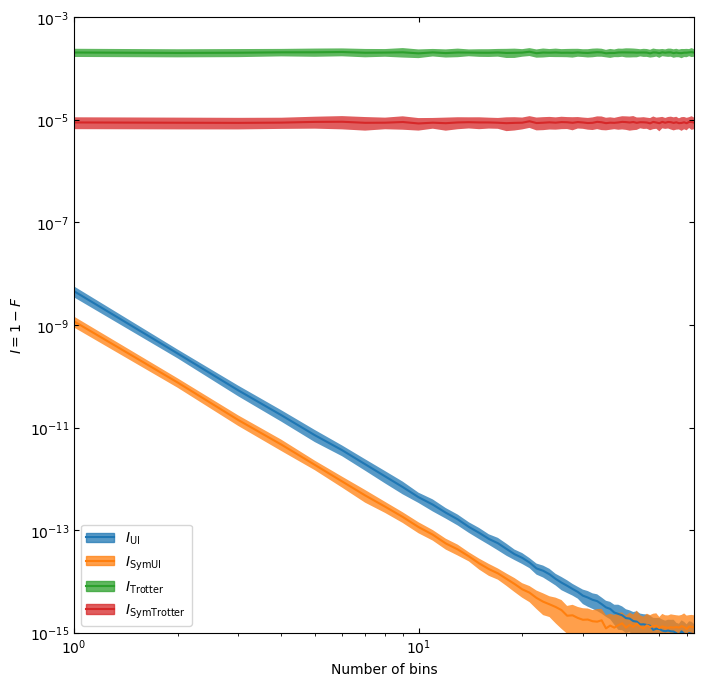

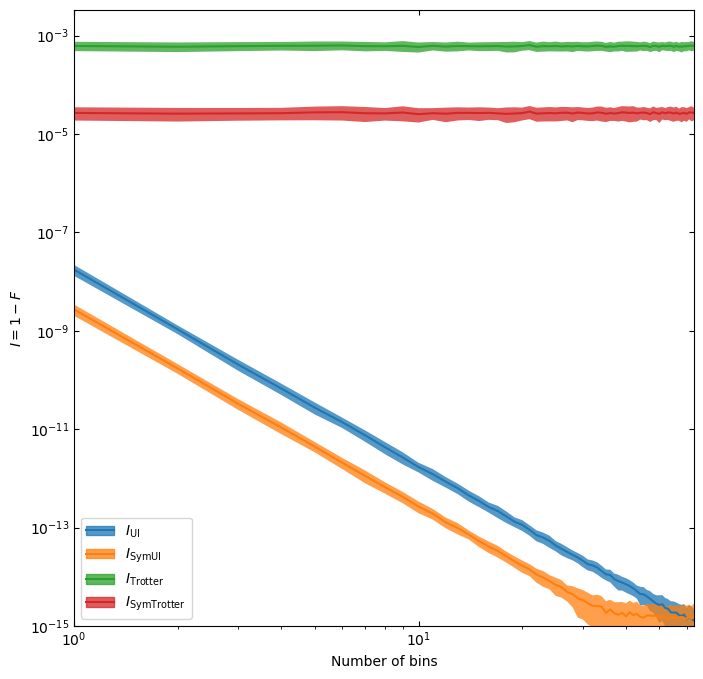

0it [00:00, ?it/s]


————— Done with amp_ratio ——————————————————————————————————————————————————————


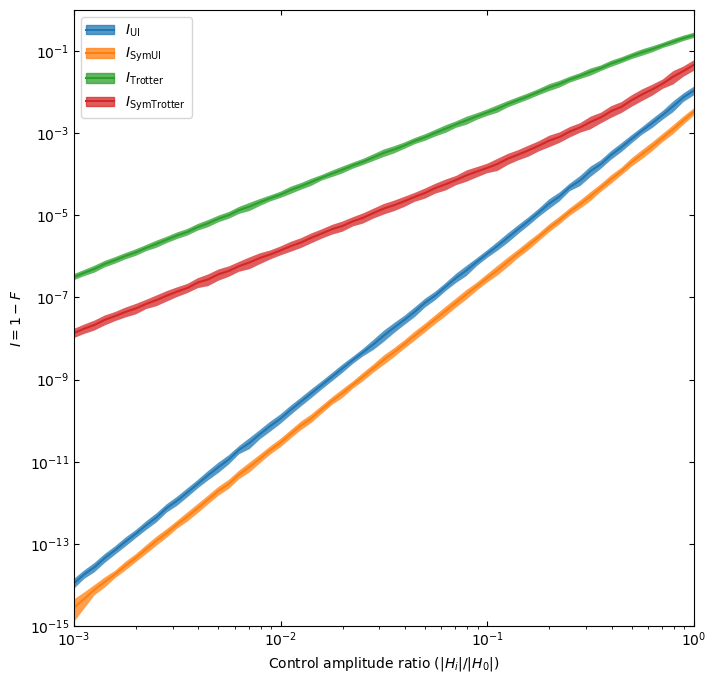

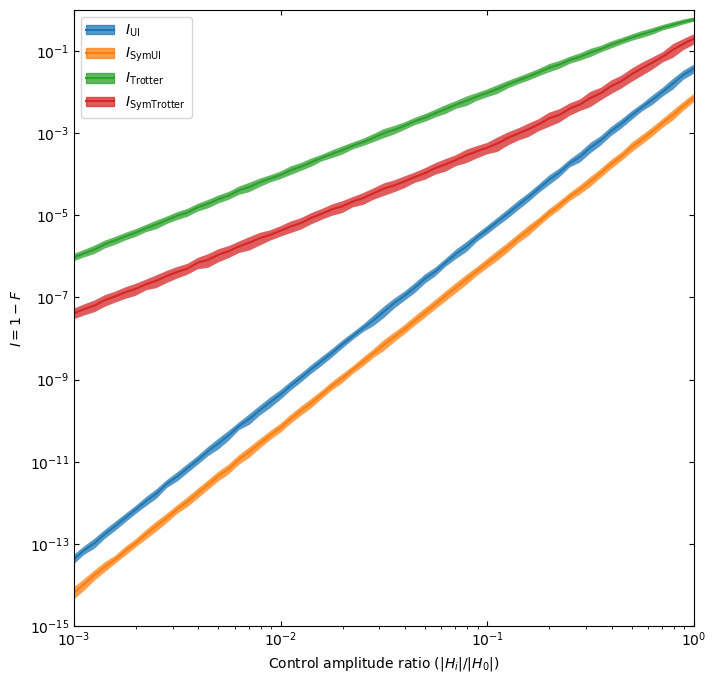

In [4]:
# Methods to use 
m_times_list    = [0]#,1,2,3,4,5,6,7,8,9,10]
m_times_list_ui = [0]#,1,2,3,4,5,6,7,8,9,10] #[0] -> single bin [10 bins are not really needed here]
method_dict = {}
method_dict['UI'] = {'method': UI, 'm_times': m_times_list_ui}
method_dict['Sym UI'] = {'method': Sym_UI, 'm_times': m_times_list_ui}
method_dict['Trotter'] = {'method': Trotter_System, 'm_times': m_times_list}
method_dict['Sym Trotter'] = {'method': Sym_Trotter_System, 'm_times': m_times_list}

combinations = ['num_controls', 'bins', 'amp_ratio']  
to_do = ['max', 'mean']#, 'times'] 
for i, combination in enumerate(combinations):
    parameters, axis_labels, axis_types = get_parameters(combination, all_parameter_dicts)  
    k = JIT_kronbinations(parameters, func=Infidelities_and_Times, other_func=other_func, import_statements=import_statements, other_arguments=[method_dict, to_do], redo=redo)
    method_dict_results, method_dict = create_variables(k, method_dict, to_do=to_do)
    k.calculate_all()
    line('Done with '+combination)
    indexes = np.where(parameters['dim_hilbert'] > 2)[0] if 'dim_hilbert' == combination else None
    # Plot the results
    axis_vars = [item for key, item in parameters.items() if key in combination]
    for plot_which in ['max', 'mean']:
        filename = plot_which+'_infidelity_by_'+combination 
        fig, ax1 = plot_infidelities(method_dict_results, axis_labels, axis_types, axis_vars, plot_which=[plot_which], figsize=figsize, ylog=True, mini=10**-15, indexes=indexes)
        # fig2tikz
        fig2tikz(fig, filename)


In [5]:
num_controls = {'label': 'Number of controls', 'name': 'num_controls', 'def_val': 2, 'variation_vals': np.arange(1, 8), 'variation_type': 'int'}
hilbert_dim = {'label':'Hilbert space dimension', 'name': 'dim_hilbert', 'def_val': 16, 'variation_vals': 2**np.arange(1, 10), 'variation_type': 'log_int'}
control_amplitudes = {'label': 'Control amplitude ratio ($|H_i| / |H_0|$)', 'name': 'amp_ratio', 'def_val': 0.025, 'variation_vals': np.logspace(-3, -2, 2), 'variation_type': 'log'} # ([H_i>0| / |H_0|)
bins = {'label': 'Number of bins', 'name': 'bins', 'def_val': 1, 'variation_vals': np.arange(1,64), 'variation_type': 'log_int'}
all_parameter_dicts = [num_controls, hilbert_dim, control_amplitudes, bins] 
import_statements = ['Analysis_Code.Average_Infidelity_Integrator', 'kronbinations', 'unipolator', ['Analysis_Code.discrete_quantum', 'dq'], ['numpy', 'np'], 'from numba import jit', 'import timeit']
other_func = [timeit_autorange, initialize_rep_arrays, intitialize_integrators, mean_std]
m_times_list_ui = [0,1,2,3,4,5,6,7,8,9,10] 
m_times_list    = [0,1,2,3,4,5,6,7,8,9,10]
method_dict = {}
method_dict['UI'] = {'method': UI, 'm_times': m_times_list_ui}
method_dict['Sym UI'] = {'method': Sym_UI, 'm_times': m_times_list_ui}
method_dict['Trotter'] = {'method': Trotter_System, 'm_times': m_times_list}
method_dict['Sym Trotter'] = {'method': Sym_Trotter_System, 'm_times': m_times_list}
redo = False
to_do = ['max', 'mean', 'times']   
combinations = ['amp_ratio']
for i, combination in enumerate(combinations):
    parameters, axis_labels, axis_types = get_parameters(combination, all_parameter_dicts)  
    k = JIT_kronbinations(parameters, func=Infidelities_and_Times, other_func=other_func, import_statements=import_statements, other_arguments=[method_dict, to_do], redo=redo, progress=True)
    method_dict_results, method_dict = create_variables(k, method_dict, to_do=to_do)
    k.calculate_all()

0it [00:00, ?it/s]


————————————————————————————————————————————————————————————————————————————————
————————————————————————————————————————————————————————————————————————————————


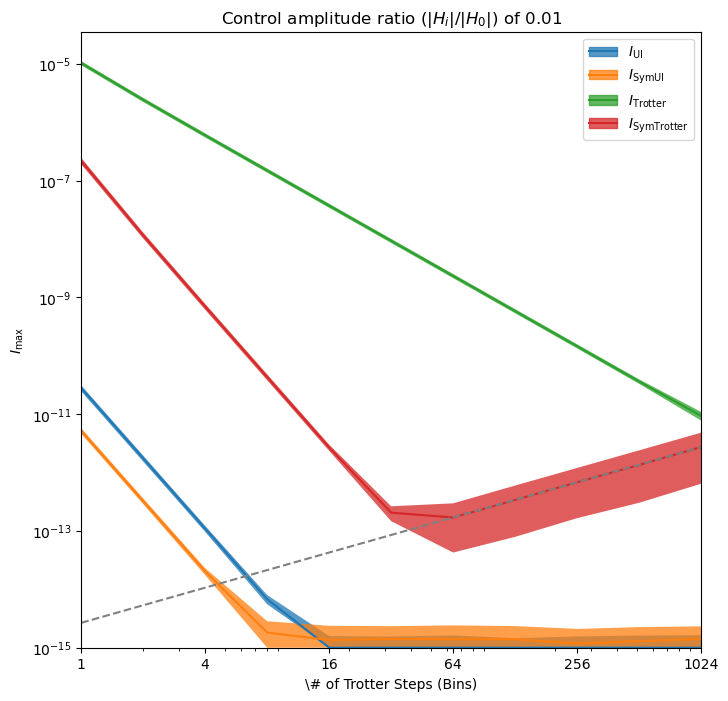

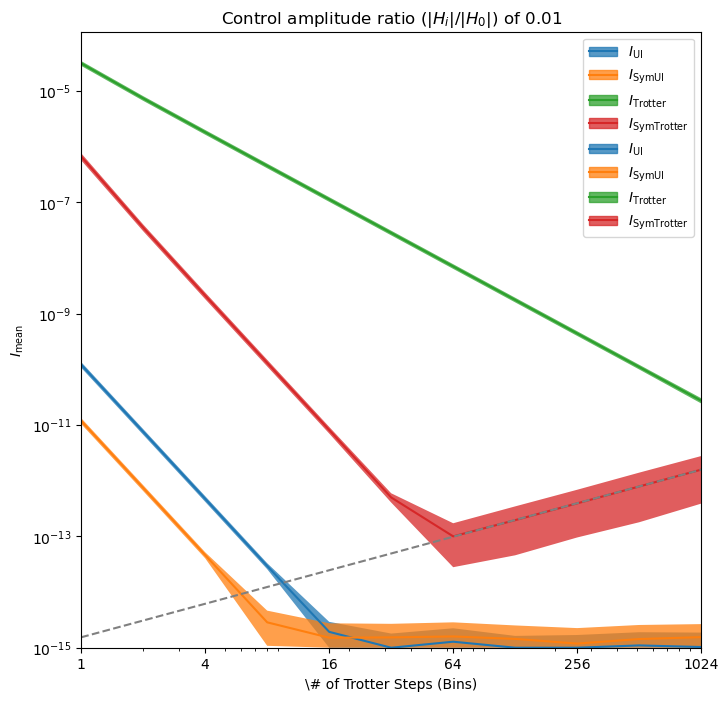

In [10]:
# plot the infidelity as a function of the number of trotter steps and the number of bins to reach a target fidelity  --> load the apropatirate data ('amp_ratio')
# fig, ax single axis
# import curve_fit
from scipy.optimize import curve_fit
# at which amp_ratio to plot ? --> allow change via slider
amp_ratio_index, amp_ratio = closest_match(parameters['amp_ratio'], 0.01)

# for every method, plot the infidelity as a function of the number of trotter steps (or the number of bins if UI)
ps = 0.68
ns = 1
legendary = []
for plot_which in ['max', 'mean']:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    for name, data in method_dict_results.items():
        if not name == 'times':
            if 'UI' in name: # use bins
                x_vals = 2**np.array(m_times_list_ui)
            else:
                x_vals = 2**np.array(m_times_list)
            # plot mean values using std_plot
            # extract values
            mean_I, std_I = data[plot_which + '_I_mean'][amp_ratio_index,:], data[plot_which + '_I_std'][amp_ratio_index,:]
            legendary, _ = std_plot(ax, x_vals, [mean_I], [std_I], ps=ps, ns=ns, label=r'$I_{\mathrm{'+name+'}}$', legendary=legendary, support=[10**-15,1.0], )
            if 'Sym Trotter' in name:
                # Fit a curve to mean_I[-3:] 
                def model(x, c):
                    return c*x
                # fit the model
                popt, pcov = curve_fit(model, x_vals[-3:], mean_I[-3:])
                # plot the fit
                ax.plot(x_vals, model(x_vals, *popt), linestyle='--', color='gray')

    # xlabel
    ax.set_xlabel(r'\# of Trotter Steps (Bins)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r'$I_{\mathrm{'+plot_which+'}}$')
    ax.legend(*legendary, loc='best')
    ylim = ax.get_ylim()
    ax.set_ylim([10**-15, ylim[1]])
    ax.set_xlim([1, 2**max(m_times_list)])
    # set xticks to 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024
    x_vals_ticks = 2**np.array(m_times_list)[::2]
    ax.set_xticks(x_vals_ticks)
    ax.set_xticklabels([str(x) for x in x_vals_ticks])
    ax.set(title=r'Control amplitude ratio ($|H_i| / |H_0|$) of '+str(round_sig(amp_ratio,1)))
    filename = plot_which + '_Steps2Infidelity_at_control_amp_ratio_'+str(round_sig(amp_ratio,1))
    fig2tikz(fig, filename)
    line()

————————————————————————————————————————————————————————————————————————————————
————————————————————————————————————————————————————————————————————————————————


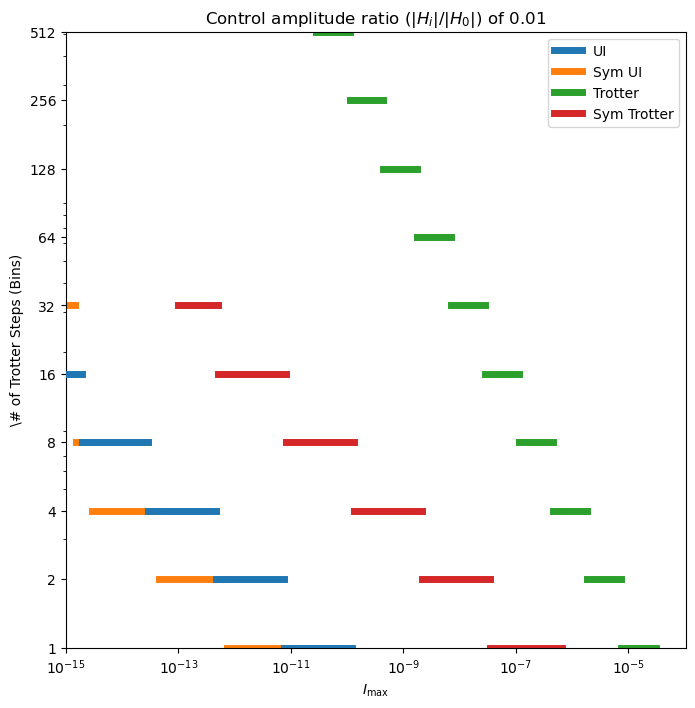

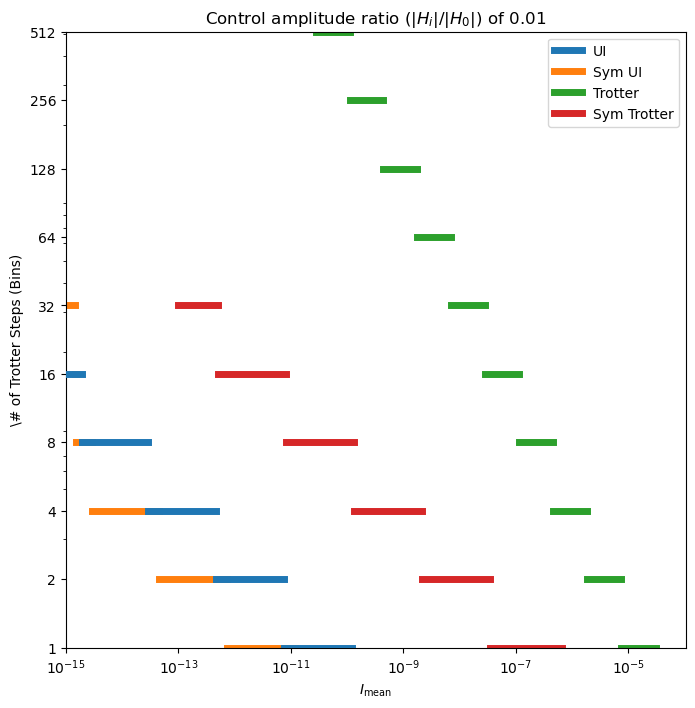

In [14]:

# plot the infidelity as a function of the number of trotter steps and the number of bins to reach a target fidelity  --> load the apropatriate data ('amp_ratio')
# fig, ax single axis
# at which amp_ratio to plot ? --> allow change via slider
amp_ratio_index, amp_ratio = closest_match(parameters['amp_ratio'], 0.01)

# for every method, plot the infidelity as a function of the number of trotter steps (or the number of bins if UI)
ps = 0.68
legendary = []
for plot_which in ['max', 'mean']:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    for d, (name, data) in enumerate(method_dict_results.items()):
        if not name == 'times':
            if 'UI' in name: # use bins
                x_vals = 2**np.array(m_times_list_ui)
            else:
                x_vals = 2**np.array(m_times_list)
            # plot mean values using std_plot
            # extract values
            mean_I, std_I = data['mean_I_mean'][amp_ratio_index,:], data['mean_I_std'][amp_ratio_index,:]
            min_I = mean_I - std_I
            max_I  = mean_I + std_I
            # Calculate the partial minima 
            # Double the va
            mean_indexes = index_partial_minimum(mean_I)#, std_I)
            mean_Is = mean_I[mean_indexes]
            min_Is = min_I[mean_indexes]
            max_Is = max_I[mean_indexes]
            fy1, fx1 = steps_xy(x_vals, mean_Is)
            # plot as steps at x_vals,  without connecting the x_vals
            color = ax._get_lines.get_next_color()    
            lw = 5
            for i in range(0,len(fx1)-2,2):
                # always plot 2 points
                if i==0:
                    ax.loglog(fx1[i:i+2], fy1[i:i+2], label=name, color=color, linewidth=lw)
                    # make line thicker
                else:
                    ax.loglog(fx1[i:i+2], fy1[i:i+2], color=color, linewidth=lw)
                if d == 0:
                    # change z order 
                    ax.lines[-1].set_zorder(100)
                # correct for line width based increase in x direction
    # xlabel
    ax.set_ylabel(r'\# of Trotter Steps (Bins)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$I_{\mathrm{'+plot_which+'}}$')
    ax.legend(*legendary, loc='best')
    xlim = ax.get_xlim()
    ax.set_xlim([10**-15, xlim[1]])
    ax.set_ylim([1, 2**(max(m_times_list)/2)])
    # set xticks to 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024
    y_vals_ticks = 2**np.array(m_times_list)#[::2]
    ax.set_yticks(y_vals_ticks[:-1])
    ax.set_yticklabels([str(y) for y in y_vals_ticks[:-1]])
    ax.set(title=r'Control amplitude ratio ($|H_i| / |H_0|$) of '+str(round_sig(amp_ratio,1)))
    line()
    filename = plot_which+'Stepped_Required_Steps2Infidelity_at_control_amp_ratio_'+str(round_sig(amp_ratio,1))
    fig2tikz(fig, filename)

In [15]:
num_controls = {'label': 'Number of controls', 'name': 'num_controls', 'def_val': 2, 'variation_vals': np.arange(1, 8), 'variation_type': 'int'}
hilbert_dim = {'label':'Hilbert space dimension', 'name': 'dim_hilbert', 'def_val': 16, 'variation_vals': 2**np.arange(1, 10), 'variation_type': 'log_int'}
control_amplitudes = {'label': 'Control amplitude ratio ($|H_i| / |H_0|$)', 'name': 'amp_ratio', 'def_val': 0.025, 'variation_vals': np.logspace(-3, -2, 2), 'variation_type': 'log'} # ([H_i>0| / |H_0|)
bins = {'label': 'Number of bins', 'name': 'bins', 'def_val': 1, 'variation_vals': np.arange(1,64), 'variation_type': 'log_int'}
all_parameter_dicts = [num_controls, hilbert_dim, control_amplitudes, bins] 
import_statements = ['Analysis_Code.Average_Infidelity_Integrator', 'kronbinations', 'unipolator', ['Analysis_Code.discrete_quantum', 'dq'], ['numpy', 'np'], 'from numba import jit', 'import timeit']
other_func = [timeit_autorange, initialize_rep_arrays, intitialize_integrators, mean_std]
m_times_list_ui = [0,1,2,3,4,5]#,6,7,8,9,10] 
m_times_list    = [0,1,2,3,4,5,6,7,8,9,10]
method_dict = {}
method_dict['UI'] = {'method': UI, 'm_times': m_times_list_ui}
method_dict['Sym UI'] = {'method': Sym_UI, 'm_times': m_times_list_ui}
method_dict['Trotter'] = {'method': Trotter_System, 'm_times': m_times_list}
method_dict['Sym Trotter'] = {'method': Sym_Trotter_System, 'm_times': m_times_list}
redo = False
to_do = ['max', 'mean', 'times']   
combinations = ['amp_ratio']
for i, combination in enumerate(combinations):
    parameters, axis_labels, axis_types = get_parameters(combination, all_parameter_dicts)  
    k = JIT_kronbinations(parameters, func=Binned_Infidelities_and_Times, other_func=other_func, import_statements=import_statements, other_arguments=[method_dict, to_do], redo=redo, progress=True)
    method_dict_results, method_dict = create_variables(k, method_dict, to_do=to_do)
    k.calculate_all()

0it [00:00, ?it/s]


————————————————————————————————————————————————————————————————————————————————
————————————————————————————————————————————————————————————————————————————————


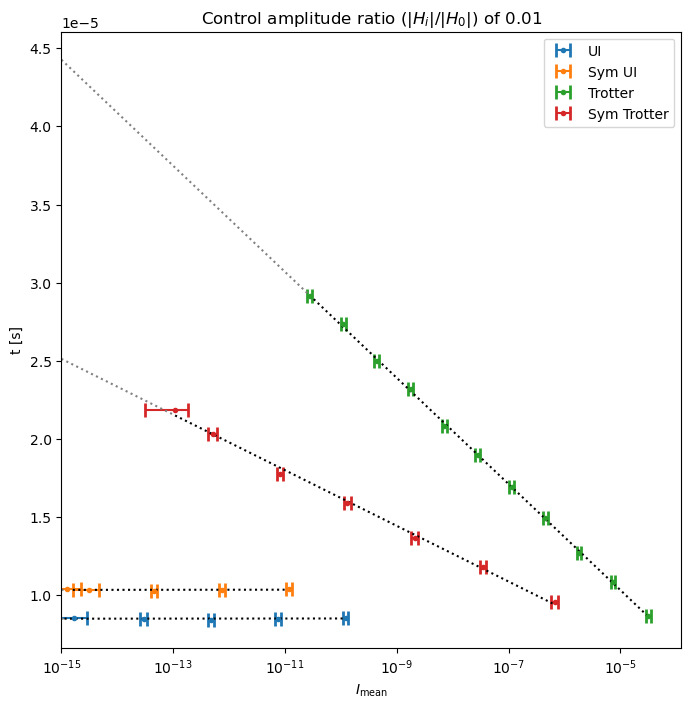

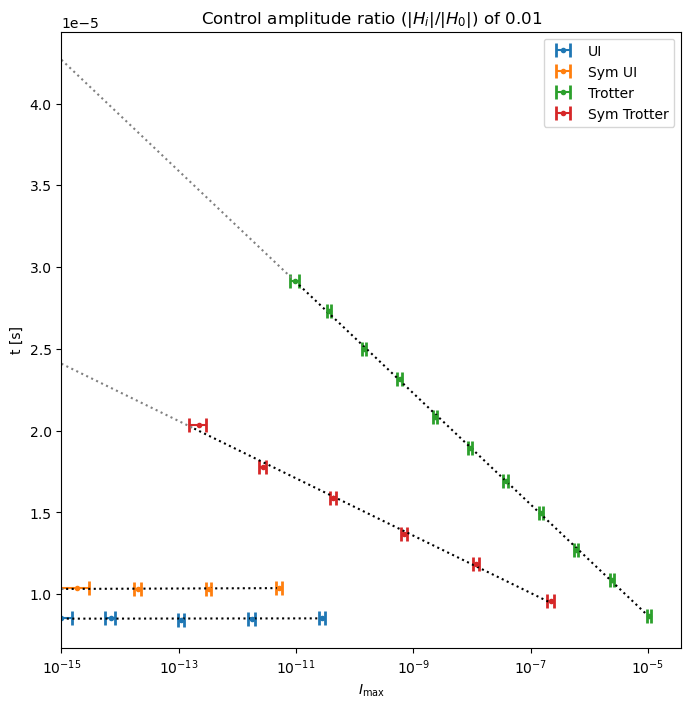

In [16]:
import scipy
# plot the infidelity as a function of the number of trotter steps and the number of bins to reach a target fidelity  --> load the apropatirate data ('amp_ratio')
# at which amp_ratio to plot ? --> allow change via slider
amp_ratio_index, amp_ratio = closest_match(parameters['amp_ratio'], 0.01)

# for every method, plot the infidelity as a function of the number of trotter steps (or the number of bins if UI)
ps = 0.68
legendary = []
min_x = 10**-15
lineparameters = {} # fit a line to the data (in logarithm, so t(I) = a + b*exp(I)
f = lambda x, a, b: a + b*np.log(x)

for plot_which in ['mean', 'max']:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    # Determine the maximum value of the infidelity
    for d, (name, data) in enumerate(method_dict_results.items()):
        if not name == 'times':
            # extract values
            mean_I, std_I = data[plot_which+'_I_mean'][amp_ratio_index,:], data[plot_which+'_I_std'][amp_ratio_index,:]
            t_vals = data['times'][amp_ratio_index,:]
            # Calculate the partial minima 
            mean_indexes = index_partial_minimum(mean_I, std_I)
            mean_Is = mean_I[mean_indexes]
            std_Is = std_I[mean_indexes]
            ts = t_vals[mean_indexes]
            # without line connecting draw errorbars
            ax.errorbar(mean_Is, ts, xerr=std_Is, capsize=5, capthick=2, label=name, fmt='o', markersize=2, markeredgewidth=2)
            # fit f to the data using scipy.optimize.curve_fit
            param, covariance = scipy.optimize.curve_fit(f, mean_Is, ts, p0=[0.1,0.1])
            std_param = np.sqrt(np.diag(covariance))
            # save in lineparameters
            lineparameters[name] = {'param': param, 'std_param': std_param}
    for d, (name, data) in enumerate(method_dict_results.items()):
        if not name == 'times':
            I = data[plot_which+'_I_mean'][amp_ratio_index,:]
            min_I, max_I = np.min(I), np.max(I)
            a, b = lineparameters[name]['param']
            x_min = np.array([min_x, min_I]) 
            x = np.array([min_I, max_I])
            ax.semilogx(x, f(x, a,b), linestyle=':', color='black')
            ax.semilogx(x_min, f(x_min, a,b), linestyle=':', color='gray')
    ax.set_ylabel(r't [s]')
    ax.set_xscale('log')
    ax.set_xlabel(r'$I_{\mathrm{' + plot_which + '}}$')
    ax.legend(*legendary, loc='best')
    xlim = ax.get_xlim()
    ax.set_xlim([min_x, xlim[1]])
    ax.set(title=r'Control amplitude ratio ($|H_i| / |H_0|$) of '+str(round_sig(amp_ratio,2)))
    line()
    filename = plot_which+'Time_to_infidelity_'+str(round_sig(amp_ratio,1))
    fig2tikz(fig, filename)

In [2]:
def plot_times(method_dicts, axis_labels, axis_types, axis_vars, figsize=(8,8), ylog=True):
    legendary = []
    #generate figure with one axis
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    for method, method_dict in method_dicts.items():
        # get the correct elements out
        mean_vals = method_dict['times']
        # plot the mean and std
        ax1.plot(axis_vars[0], mean_vals.array(), label=r'$I_{\mathrm{'+method+'}}$')
    # set the axis labels
    ax1.set_xlabel(axis_labels[0])
    ax1.set_ylabel('$t [s]$')
    ax1.set(xlim=(axis_vars[0][0], axis_vars[0][-1]))
    if ylog:
        ax1.set_yscale('log')
    if axis_types[0] == 'log':
        ax1.set_xscale('log')
    # get ylim
    ylim = ax1.get_ylim()
    if ylim[0] < mini:
        ylim = (mini, ylim[1])
    if ylim[1] > 1:
        ylim = (ylim[0], 1)
    ax1.set(ylim=ylim)
    # set the legend
    ax1.legend()
    return fig, ax1

In [4]:
num_controls = {'label': 'Number of controls', 'name': 'num_controls', 'def_val': 2, 'variation_vals': np.arange(1, 8), 'variation_type': 'int'}
hilbert_dim = {'label':'Hilbert space dimension', 'name': 'dim_hilbert', 'def_val': 16, 'variation_vals': 2**np.arange(1, 10), 'variation_type': 'log_int'}
control_amplitudes = {'label': 'Control amplitude ratio ($|H_i| / |H_0|$)', 'name': 'amp_ratio', 'def_val': 0.025, 'variation_vals': np.logspace(-3, 0, 61), 'variation_type': 'log'} # ([H_i>0| / |H_0|)
bins = {'label': 'Number of bins', 'name': 'bins', 'def_val': 1, 'variation_vals': np.arange(1,64), 'variation_type': 'log_int'}
all_parameter_dicts = [num_controls, hilbert_dim, control_amplitudes, bins] 
import_statements = ['Analysis_Code.Average_Infidelity_Integrator', 'kronbinations', 'unipolator', ['Analysis_Code.discrete_quantum', 'dq'], ['numpy', 'np'], 'from numba import jit', 'import timeit']
other_func = [timeit_autorange, initialize_rep_arrays, intitialize_integrators, mean_std]
m_times_list_ui = [0]
m_times_list    = [0]
method_dict = {}
method_dict['UI'] = {'method': UI, 'm_times': m_times_list_ui}
method_dict['Sym UI'] = {'method': Sym_UI, 'm_times': m_times_list_ui}
method_dict['Trotter'] = {'method': Trotter_System, 'm_times': m_times_list}
method_dict['Sym Trotter'] = {'method': Sym_Trotter_System, 'm_times': m_times_list}
redo = False
to_do = ['times']   
combinations = ['dim_hilbert']
for i, combination in enumerate(combinations):
    parameters, axis_labels, axis_types = get_parameters(combination, all_parameter_dicts)  
    k = JIT_kronbinations(parameters, func=Binned_Infidelities_and_Times, other_func=other_func, import_statements=import_statements, other_arguments=[method_dict, to_do], redo=redo, progress=True)
    method_dict_results, method_dict = create_variables(k, method_dict, to_do=to_do)
    k.calculate_all()






100%|██████████| 100/100 [00:00<00:00, 241.85it/s]






100%|██████████| 100/100 [00:00<00:00, 166.83it/s]






100%|██████████| 100/100 [00:00<00:00, 137.12it/s]










100%|██████████| 100/100 [00:01<00:00, 70.59it/s]






































100%|██████████| 100/100 [00:06<00:00, 14.38it/s]





































































































100%|██████████| 100/100 [00:28<00:00,  3.55it/s]





































































































100%|██████████| 100/100 [01:13<00:00,  1.36it/s]





































































































100%|██████████| 100/100 [03:53<00:00,  2.33s/it]





































































































100%|██████████| 9/9 [25:21<00:00, 169.07s/it]


In [141]:
redo = Fasle
# Variation by different variables, 
# specify the variables by a dictionary 
for i, combination in enumerate([combinations[2]]):
    parameters, axis_labels, axis_types = get_parameters(combination, all_parameter_dicts)  
    k = JIT_kronbinations(parameters, func=Binned_Infidelities_and_Times, other_func=[timeit_autorange], import_statements=import_statements, other_arguments=method_dict, redo=redo, progress=True)
    method_dict_list = create_variables(k, method_dict.keys(), times=True, only_times=True)
    method_dict_list['Eigh'] = {'times': k.empty()}
    # Plot the results
    axis_vars = [item for key, item in parameters.items() if key in combination]
    filename = 'times_by_'+combination+'.tex'
    fig, ax1 = plot_times(method_dict_list, axis_labels, axis_types, axis_vars, figsize=(8,8), ylog=True)
    subfig_str = figs2tikz([fig], 'Speed', filename, [3,1], figsize=figsize, width=width, standalone=False, add_letters=0)
    line('filename')
    print(os.path.join('Infidelity', filename))

NameError: name 'Fasle' is not defined